# WNBA Location Charts

Unfortunately, the same `stats.nba.com` endpoint cannot be used to generate WNBA shot charts. However, these data are available through `data.wnba.com`! This notebook uses the same methodology already followed for generating shot, foul, turnover, and assist charts.

The following explores the `wnba_shots.Shots` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `pbp` endpoint of the `data.wnba.com`. Because this is play-by-play data, the `Shots` name is a bit of a misnomer. The goal of this analysis is to build charts that visualize shooting, fouling, and passing data. Note, you will need version `1.0.1` of `py_ball` or the version currently on the `master` branch of the `py_ball` repository.

## Shot Charts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

import time

from py_ball import wnba_shots

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `Shots` class requires a few parameters:
- season: YYYY season year format
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 preseason game between the Mystics and the Dream.

In [12]:
game_id = '1041900402'
season = '2019'

shots = wnba_shots.Shots(headers=HEADERS,
                         game_id=game_id,
                         season=season)
shot_df = pd.DataFrame(shots.data)
shot_df.head(15)

,evt,cl,de,locX,locY,opt1,opt2,mtype,etype,opid,tid,pid,hs,vs,epid,oftid,ord
0,2,10:00,Start Period,0,-80,0,0,0,12,,0,0,0,0,,0,20000
1,4,09:56,Jump Ball Sanders vs Jones (Delle Donne gains ...,0,-80,0,0,0,10,1627673,1611661322,201506,0,0,203399,1611661322,60000
2,7,09:55,[WAS] Delle Donne Turnover : Out of Bounds Los...,115,67,0,0,40,5,,1611661322,203399,0,0,,1611661322,70000
3,8,09:40,[CON] Jones Driving Bank Hook Shot: Missed,91,64,2,0,93,2,,1611661323,1627673,0,0,,1611661323,80000
4,9,09:36,[WAS] Delle Donne Rebound (Off:0 Def:1),91,64,0,0,0,4,,1611661322,203399,0,0,,1611661323,90000
5,10,09:23,[WAS 2-0] Atkins Pullup Jump shot: Made (2 PTS),-76,84,2,0,79,1,,1611661322,1628878,2,0,,1611661322,100000
6,11,09:07,[CON] Thomas Turnover : Out of Bounds - Bad Pa...,-12,185,0,0,45,5,,1611661323,203826,2,0,,1611661323,110000
7,12,08:57,[WAS] Toliver 3pt Shot: Missed,-189,144,3,0,1,2,,1611661322,201911,2,0,,1611661322,120000
8,13,08:56,[CON] Team Rebound,-189,144,0,0,0,4,,1611661323,0,2,0,,1611661322,130000
9,14,08:56,Stoppage: Out-of-Bounds,0,-80,0,0,3,20,,0,0,2,0,,1611661323,140000


In [20]:
shot_df = pd.read_csv('../shot_probability/wnba_shotchart_2019.csv')

In [21]:
shot_df[(shot_df['tid']==1611665410) & (shot_df['etype']==2)]

,evt,cl,de,locX,locY,opt1,opt2,mtype,etype,opid,tid,pid,hs,vs,epid,oftid,ord


Let's attempt to define as many columns as we can:
- `cl`: Game time remaining in the period in MM:SS format
- `de`: Play description
- `epid`: Player ID of the "extra" player (assisting player or player subbed in, for example)
- `etype`: Event type indicators. Viewing the above seems to indicate that a 1 is a made shot, 2 is a missed shot, and 4 is a rebound
- `evt`: This appears to be an order of events
- `hs`: Home score
- `locX`: x-location of the play
- `locY`: y-location of the play
- `mtype`: More granulat event type indicator
- `pid`: Player ID of the main actor on a play
- `tid`: Team ID of the main actor on a play
- `oftid`: Team ID of the offensive team
- `vs`: Visitor score

The following draws a WNBA half court on which the shot charts will be plotted.

In [22]:
def draw_court():
    """ draw_court draws an WNBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an WNBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 35], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 35], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=222.17*2, height=222.17*2, theta1=8, theta2=172, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

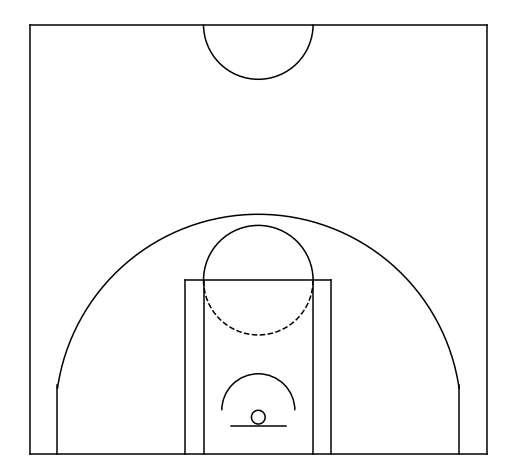

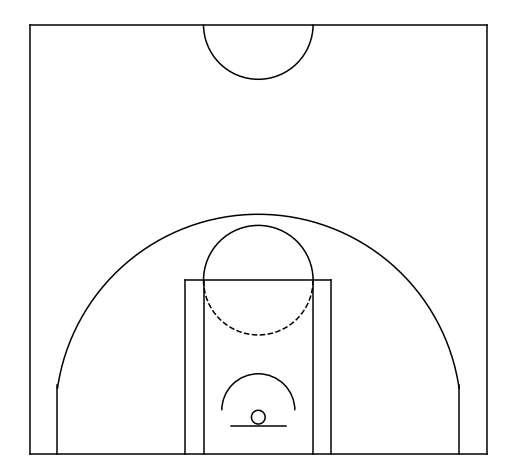

In [23]:
court, court_axis = draw_court()
court

With the court visualization, the next step is to write a function that plots shots for a given player or team.

In [60]:
def plot_shot(shot_df, player_or_team, unit_id):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with locX and
        locY columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df#[shot_df['tid']==unit_id]
        court_axis.set_title("2019 WNBA FGA", fontsize=14)
    else:
        shot = shot_df[shot_df['pid']==unit_id]
        court_axis.set_title('Jonquel Jones', fontsize=14)

    miss_df = shot[shot['etype']==2]
    make_df = shot[shot['etype']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['locX'], make_df['locY'], 'co', alpha=0.05, label='Make')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['locX'], miss_df['locY'], 'co', alpha=0.05, label='Miss')

#     plt.legend(loc='upper right')
    plt.close()
    return court

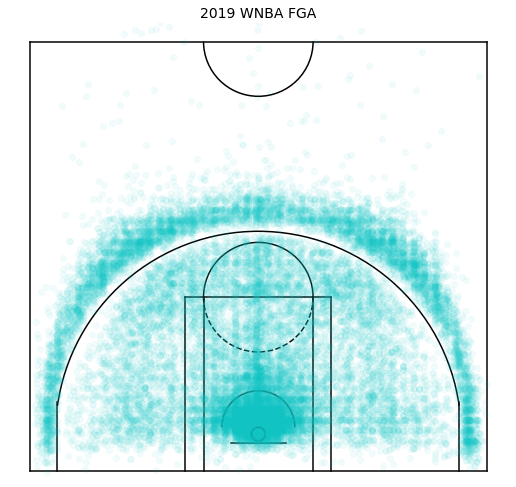

In [61]:
plot_shot(shot_df, 'team', 1611661323)

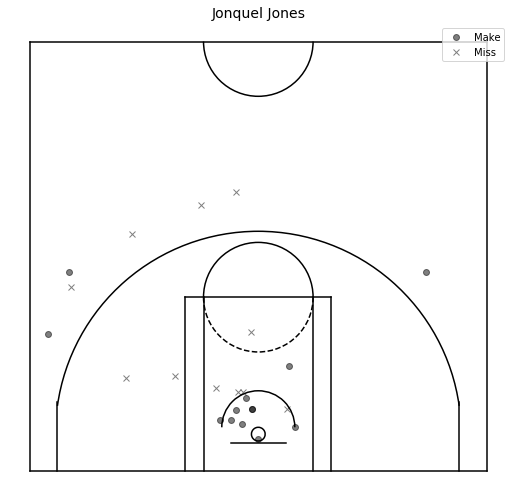

In [17]:
plot_shot(shot_df, 'player', 1627673)

Shatori Walker-Kimbrough had a great shooting performance, going 7-9 from the field including 3-3 from three-point land for 15 points.

## Assist Charts

Assists seem to be encoded as made shots (`etype == 1`) with the `epid` filled in. Let's check out the play descriptions for such plays to confirm.

In [8]:
for desc in shot_df[(shot_df['etype'] == 1) & (shot_df['epid'] != '')]['de']:
    print(desc)

[CHI 2-0] Dolson Jump Shot: Made (2 PTS) Assist: Vandersloot (1 AST)
[CHI 4-0] DeShields Floating Jump shot: Made (2 PTS) Assist: Dolson (1 AST)
[CHI 8-0] Dolson Layup Shot: Made (4 PTS) Assist: DeShields (1 AST)
[WAS 2-8] Powers Driving Layup Shot: Made (2 PTS) Assist: Walker-Kimbrough (1 AST)
[WAS 4-8] Powers Driving Layup Shot: Made (4 PTS) Assist: Cloud (1 AST)
[WAS 7-8] Sanders Turnaround Jump Shot: Made (2 PTS) Assist: Powers (1 AST)
[WAS 12-8] Powers 3pt Shot: Made (8 PTS) Assist: Sanders (1 AST)
[CHI 11-12] DeShields 3pt Shot: Made (5 PTS) Assist: Vandersloot (2 AST)
[CHI 17-14] DeShields Cutting Layup Shot: Made (7 PTS) Assist: Vandersloot (3 AST)
[WAS 18-21] Meesseman Layup Shot: Made (2 PTS) Assist: Cloud (2 AST)
[WAS 20-23] Meesseman Layup Shot: Made (4 PTS) Assist: Atkins (1 AST)
[CHI 30-23] Dolson Layup Shot: Made (6 PTS) Assist: Williams (1 AST)
[WAS 26-30] Hawkins 3pt Shot: Made (4 PTS) Assist: Powers (2 AST)
[WAS 32-30] Delle Donne 3pt Shot: Made (6 PTS) Assist: Powers

Nice! These plays do indeed contain assisted baskets. Now, let's plot the location of the made baskets that resulted from the assists of Renee Montgomery of the Dream, along with her team's assists.

In [68]:
def plot_ast(ast_df, player_or_team, unit_id):
    """ plot_ast plots an assist or list of assists given in the
    assist DataFrame provided

    @param ast_df (DataFrame): DataFrame of assists with locX and
        locY columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of assist chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the assists plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
#         ast = ast_df[(ast_df['tid']==unit_id) & (ast_df['epid']!='') & (ast_df['etype']==1)]
        ast = ast_df[(ast_df['epid']!='') & (ast_df['etype']==1)]
        court_axis.set_title('2019 WNBA Assisted FGA')
#         if len(ast)>0:
#             court_axis.set_title(ast['TEAM_NAME'].iloc[0], fontsize=14)
    else:
        ast = ast_df[(ast_df['epid']==str(unit_id)) & (ast_df['etype']==1)]
        court_axis.set_title('Courtney Vandersloot', fontsize=14)
#         if len(ast)>0:
#             court_axis.set_title(ast['PLAYER2_NAME'].iloc[0], fontsize=14)


    if len(ast_df)>0:
        court_axis.plot(-ast['locX'], ast['locY'], 'yo', alpha=0.05, label='Assist')

#     plt.legend(loc='upper right')
    plt.close()
    return court

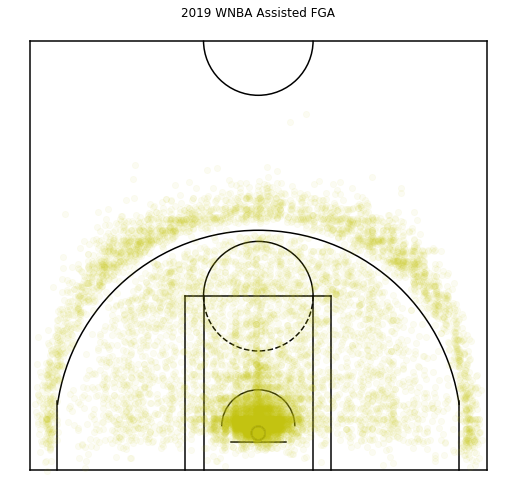

In [69]:
plot_ast(shot_df, 'team', 1611661329)

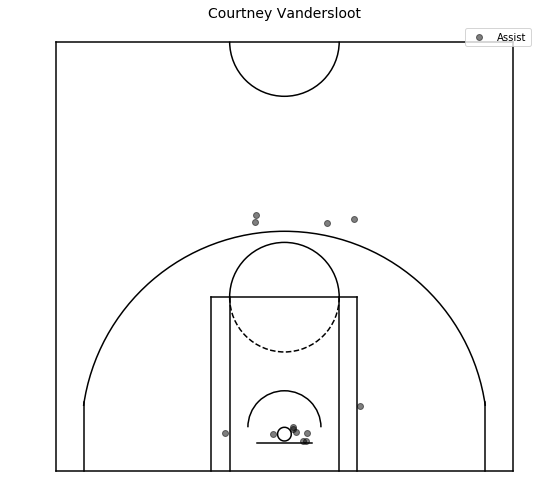

In [17]:
plot_ast(shot_df, 'player', 202664)

Montgomery registered 4 of the Dream's 11 assists, all to the left side of the basket.

## Turnover Charts

Turnovers have a huge impact on the result of a game, so visualizing the distribution and volume of turnovers should provide insight. Turnovers are encoded by `etype == 5`.

In [11]:
shot_df[shot_df['etype']==5]

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
8,09:05,[WAS] Delle Donne Turnover : Out of Bounds - B...,,5,15,2,-169,199,45,1611661322,,0,0,150000,203399,1611661322,0
44,06:03,[WAS] Team Turnover : Shot Clock Turnover,,5,64,8,22,48,11,1611661322,,0,0,640000,0,1611661322,5
52,05:13,[CHI] Dolson Turnover : Bad Pass (1 TO) Steal:...,,5,73,8,14,230,1,1611661329,1628278,1,0,730000,203828,1611661329,7
66,03:22,[CHI] DeShields Turnover : Bad Pass (1 TO) Ste...,,5,90,13,168,113,1,1611661329,201506,1,0,900000,1628890,1611661329,12
73,02:46,[WAS] Meesseman Turnover : Bad Pass (1 TO) Ste...,,5,100,13,75,42,1,1611661322,203838,1,0,1000000,203416,1611661322,14
78,02:06,[WAS] Cloud Turnover : Bad Pass (1 TO) Steal:V...,,5,107,17,-56,344,1,1611661322,202664,1,0,1070000,204333,1611661322,14
85,01:46,[WAS] Hawkins Turnover : Bad Pass (1 TO) Steal...,,5,119,19,-213,-8,1,1611661322,1628931,1,0,1190000,203403,1611661322,14
95,00:17.0,[WAS] Meesseman Turnover : Traveling (2 TO),,5,134,23,217,117,4,1611661322,,0,0,1340000,203416,1611661322,18
107,08:56,[WAS] Hawkins Turnover : Offensive Foul Turnov...,,5,158,26,60,42,37,1611661322,,0,0,1560000,203403,1611661322,20
121,07:27,[CHI] Dolson Turnover : Bad Pass (2 TO) Steal:...,,5,178,30,6,83,1,1611661329,1628278,1,0,1760000,203828,1611661329,26


Similarly to the assists, let's plot the turonver location for Renee Montgomery and the Atlanta Dream.

In [74]:
def plot_turnover(shot_df, player_or_team, unit_id):
    """ plot_turnover plots turnover locations given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of turnovers with locX and
        locY columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of turnover chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the turnovers plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df#[shot_df['tid']==unit_id]
        court_axis.set_title('2019 WNBA Turnovers', fontsize=14)
    else:
        shot = shot_df[shot_df['pid']==unit_id]
        court_axis.set_title('Courtney Vandersloot', fontsize=14)

    to_df = shot[shot['etype']==5]

    if len(to_df)>0:
        court_axis.plot(-to_df['locX'], to_df['locY'], 'mo', alpha=0.05, label='Turnover')

#     plt.legend(loc='upper right')
    plt.close()
    return court

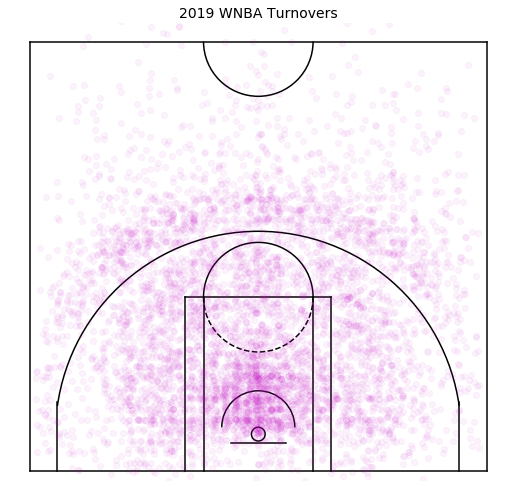

In [75]:
plot_turnover(shot_df, 'team', 1611661329)

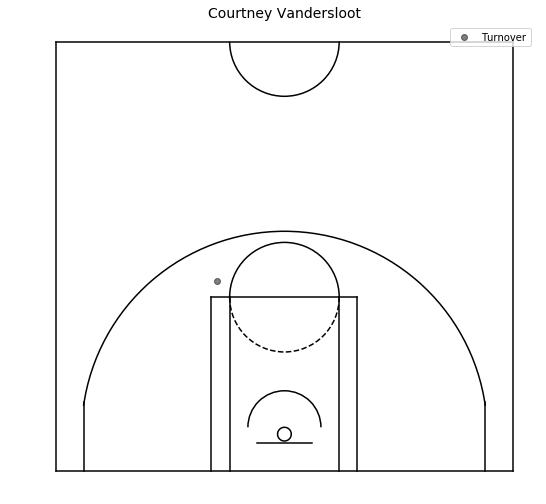

In [13]:
plot_turnover(shot_df, 'player', 202664)

The Dream lost the turnover battle with 11 turnovers, but Montgomery secured a 4-to-1 turnover ratio.

## Shooting Fouls Drawn Charts

The last chart we'll make here is a fouls drawn chart. For players that challenge the defense and get to the free throw line, such a chart can reveal attack locations that do not show up in shot charts. Fouls are encoded by `etype == 6` with the player drawing the foul encoded by `opid`. Shooting fouls are further encoded by `mtype == 2`.

In [8]:
shot_df[(shot_df['etype']==6) & (shot_df['opid']=='203026')]

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs


In [77]:
def plot_foul(shot_df, player_or_team, unit_id):
    """ plot_foul plots a foul or list of fouls given in the
    foul DataFrame provided

    @param foul_df (DataFrame): DataFrame of fouls with locX and
        locY columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of foul chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the fouls plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df#[shot_df['oftid']==unit_id]
        court_axis.set_title('2019 WNBA Shooting Fouls Drawn', fontsize=14)
    else:
        shot = shot_df[shot_df['opid']==str(unit_id)]
        court_axis.set_title('Jonquel Jones', fontsize=14)

    foul_df = shot[(shot['etype']==6) & (shot['mtype']==2)]

#     foul_df['locY'] = [x - 470 if x > 470 else x for x in foul_df['locY']]
    if len(foul_df)>0:
        court_axis.plot(-foul_df['locX'], foul_df['locY'], 'go', alpha=0.05, label='Shooting Foul Drawn')

#     plt.legend(loc='upper right')
    plt.close()
    return court

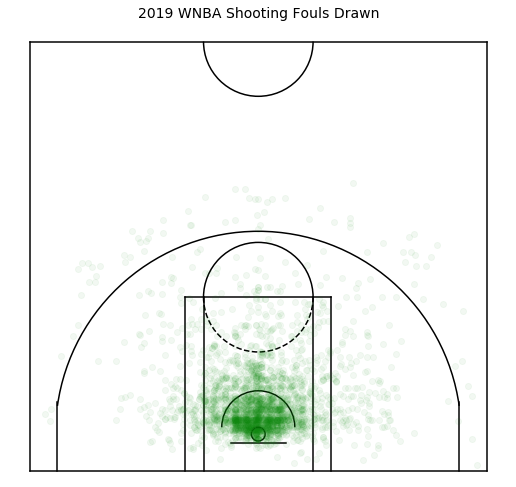

In [78]:
plot_foul(shot_df, 'team', 1611661329)

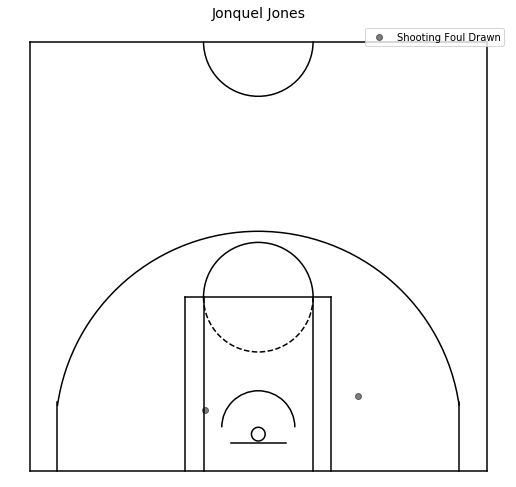

In [19]:
plot_foul(shot_df, 'player', 1627673)

Tiffany Hayes drew three shooting fouls, leading to 7 free throws made. The Dream as a whole had 27 free throw attempts.

## Exploration

- The above charts show location data for a single team. Try to pull more data for a given team or player and generate visualizations that show longer-term trends in shooting, assist, turnover, or foul data.
- Can you find another interesting field or data point to visualize?